In [1]:
import gpxpy

import requests
import itertools
import polyline

import pandas as pd

import matplotlib.pyplot as plt
import contextily as ctx

import xml.dom.minidom
from xml.etree.ElementTree import Element, SubElement, tostring

from utils import (
    get_gpx_df,
    plot_map,
)

In [2]:
DEFAULT_RADIUS_IN_METERS = 10

In [3]:
def osrm_format(coords):
    lat, lon = coords
    return f"{lon},{lat}"

def get_match(points):
    radiuses = ';'.join([str(DEFAULT_RADIUS_IN_METERS)] * len(points))
    points = ';'.join(map(osrm_format, points))
    
    params = {
        'geometries': 'polyline6',
        'radiuses': radiuses,
    } 
    response = requests.get(f"http://127.0.0.1:6000/match/v1/foot/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    route = [
        polyline.decode(matching['geometry'], 6) 
        if matching['confidence'] > 0.90
        else []
        for matching in routes['matchings']
    ]

    return list(itertools.chain.from_iterable(route))

def create_gpx(route, filename):
    gpx = Element('gpx', {
        'creator': 'Evgeny Arbatov',
        'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
        'xsi:schemaLocation': 'http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd',
        'version': '1.1',
        'xmlns': 'http://www.topografix.com/GPX/1/1'
    })
    trk = SubElement(gpx, "trk")
    trkseg = SubElement(trk, "trkseg")

    for lat, lng in route:
        SubElement(trkseg, "trkpt", attrib={"lat": str(lat), "lon": str(lng)})

    gpx = xml.dom.minidom.parseString(
        tostring(gpx, encoding="unicode")
    ).toprettyxml() 
        
    with open(filename, "w") as f:
        f.write(gpx)

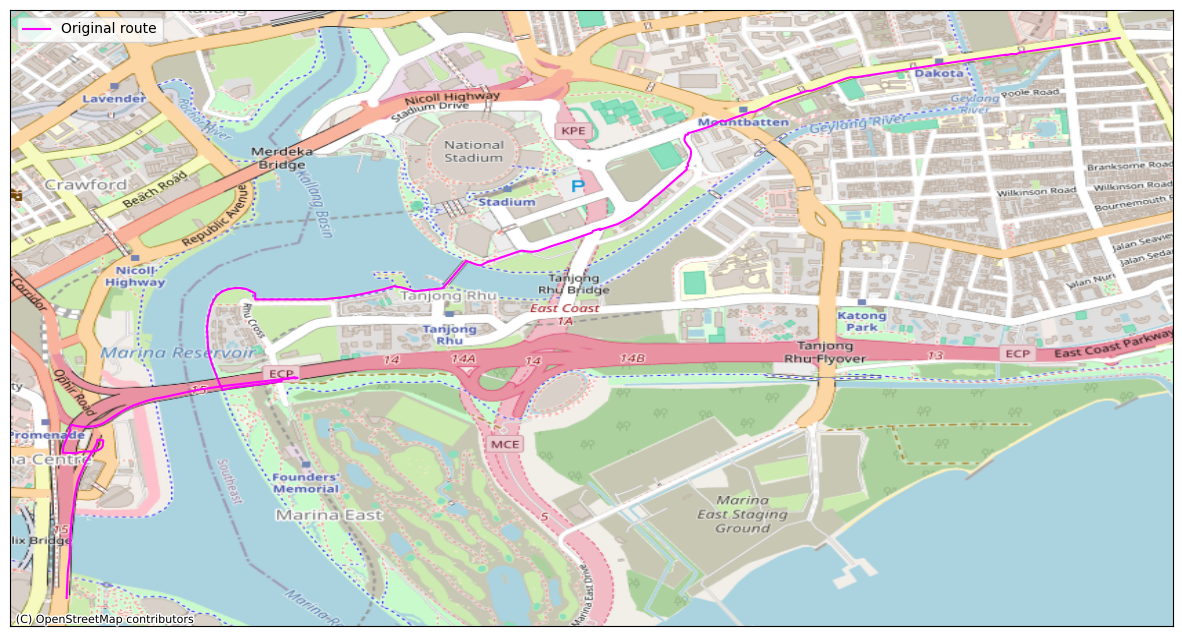

In [4]:
df = get_gpx_df('../singapore/benjamin-sheares-bridge/original-route.gpx')
plot_map(df, 'magenta', 'Original route')

In [5]:
points = list(zip(df['lat'].tolist(), df['lon'].tolist()))

complete_route = []

for (_, row1), (_, row2) in zip(df.iterrows(), df.iloc[1:].iterrows()):
    matched_route = get_match([
        (row1['lat'], row1['lon']),
        (row2['lat'], row2['lon']),
    ])
    complete_route.append(matched_route)

complete_route = list(itertools.chain.from_iterable(complete_route))
create_gpx(complete_route, '../singapore/benjamin-sheares-bridge/route.gpx')

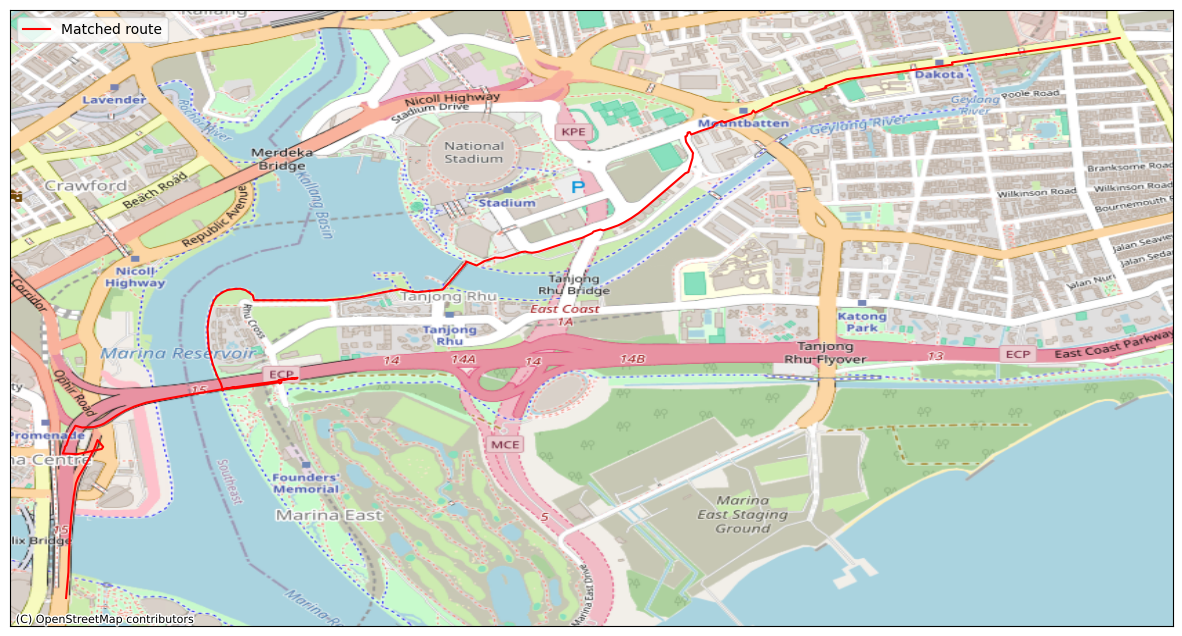

In [6]:
df = get_gpx_df('../singapore/benjamin-sheares-bridge/route.gpx')
plot_map(df, 'red', 'Matched route')